In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [2]:
norm_tpm = pd.read_csv('tables/scone_norm_tpm.tab.gz', sep='\t', index_col=0)


In [3]:
glia = norm_tpm.columns[(norm_tpm.loc['Hepacam'] >= 1) | (norm_tpm.loc['Ednrb'] >= 1)  | (norm_tpm.loc['Olig1'] >= 1) | (norm_tpm.loc['Ramp1'] >= 1) | (norm_tpm.loc['Aldh1l1'] >= 1)]
neurogenesis_cells = [x for x in norm_tpm.columns if x not in glia]
norm_tpm_neuro = norm_tpm[neurogenesis_cells]

In [4]:
import igraph as ig

In [5]:
from numba import jit

def compute_cell_metric_light(
    manifold, 
    n_neighbors=100, 
    weight_metric = True,
):
    
    
    cells = manifold.index
    n_cells = len(cells)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors+1).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    
    
    neighbor_indices = pd.DataFrame(indices, index=cells)
    
    weights = np.ones((len(cells), (n_neighbors+1)))
    
    for i in tqdm(range(len(manifold.index)), position=0, leave=True):
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            d = distances[i][j]
            w = compute_weight(d, sigma)
            weights[i, j] = w
        
    cell_metric = (indices, weights)
    return cell_metric

# @jit(nopython=True)
def compute_weight(d, sigma):
    return np.exp(-(d**2)/(sigma**2)) 


In [6]:
high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) > 0.1]
fano = (norm_tpm_neuro.loc[high_expression].var(axis=1)/norm_tpm_neuro.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)
pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm_neuro.loc[fano.index[-5000:]].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[fano.index[-5000:]].T)
# pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.loc[fano.index[-500:]].T)

rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = neurogenesis_cells
rd.PC_2 = - rd.PC_2


cell_metric = compute_cell_metric_light(rd, n_neighbors=5)

100%|██████████| 1067/1067 [00:00<00:00, 19930.36it/s]


In [60]:
var_genes = pd.read_csv('~/variable_genes.csv')
var_genes = np.array(var_genes).reshape(1, -1)[0]
var_genes = pd.Index(sorted(set([x for x in var_genes if type(x)==str])))

In [94]:
high_expression = norm_tpm_neuro.index[norm_tpm_neuro.mean(axis=1) > 0.1]
fano = (norm_tpm_neuro.loc[high_expression].var(axis=1)/norm_tpm_neuro.loc[high_expression].mean(axis=1)).sort_values()
pca_norm_tiklova = PCA(n_components=30)
pca_norm_tiklova = pca_norm_tiklova.fit(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)

pca_norm_tiklova = pca_norm_tiklova.fit_transform(norm_tpm_neuro.loc[var_genes & norm_tpm_neuro.index].T)
# pca_norm_tiklova = pca_norm_tiklova.fit_transform(scaled_counts.loc[fano.index[-500:]].T)

rd = pd.DataFrame()
for i in range(30):
    rd['PC_' + str(i+1)] = pca_norm_tiklova.T[i]

rd.index = neurogenesis_cells
rd.PC_2 = - rd.PC_2


In [96]:
rd[['PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5']].to_csv('tables/pc5_rd_all.tab.gz', sep='\t', index=True, header=True)

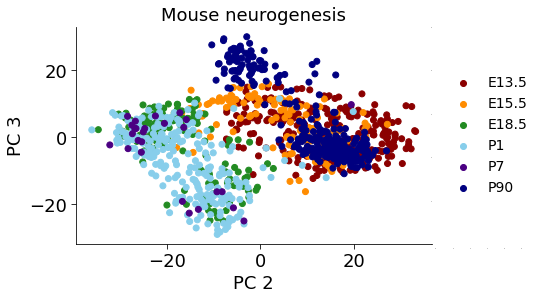

In [92]:

meta = pd.read_csv('../SraRunTable.txt.gz', index_col=0)

from matplotlib import pyplot as plt
colores = []
for cell in meta.loc[rd.index].Age:
    if cell == 'embryonic day 13.5':
        colores.append('darkred')
    if cell == 'embryonic day 15.5':
        colores.append('darkorange')
    if cell == 'embryonic day 18.5':
        colores.append('forestgreen')
    if cell == 'postnatal day 1':
        colores.append('skyblue')
    if cell == 'postnatal day 7':
        colores.append('indigo')
    if cell == 'postnatal day 90':
        colores.append('navy')
        
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1,5)
gs.update(wspace=0.05, hspace=0.10)
ax = fig.add_subplot(gs[0,0:4])
ax_2 = fig.add_subplot(gs[0,4])
ax.scatter(rd.PC_2, rd.PC_3, c=colores)
ax.tick_params(labelsize=18, length=5)
ax.set_title('Mouse neurogenesis', fontsize=18)
ax.set_xlabel('PC 2', fontsize=18)
ax.set_ylabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax_2.scatter([-1], [0], c='darkred', label='E13.5')
ax_2.scatter([0], [0], c='darkorange', label='E15.5')
ax_2.scatter([0], [0], c='forestgreen', label='E18.5')
ax_2.scatter([0], [0], c='skyblue', label='P1')
ax_2.scatter([0], [0], c='indigo', label='P7')
ax_2.scatter([0], [0], c='navy', label='P90')
ax_2.spines["right"].set_visible(False)
ax_2.spines["top"].set_visible(False)
ax_2.spines["bottom"].set_visible(False)
ax_2.spines["left"].set_visible(False)
ax_2.tick_params(labelsize=0, length=0, which='both')
ax_2.set_xlim([2, 3])
ax_2.set_ylim([2, 3])
ax_2.legend(frameon=False, fontsize=14, loc='center left')

# plt.savefig('../../plots/PCA_neurogenesis.png', bbox_inches='tight', res=100)
# plt.savefig('../../plots/PCA_neurogenesis.svg', bbox_inches='tight')
# plt.savefig('../../plots/PCA_neurogenesis.pdf', bbox_inches='tight')

In [23]:
from sklearn.manifold import TSNE

t = TSNE().fit_transform(norm_tpm_neuro.loc[fano.index[-500:]].T)

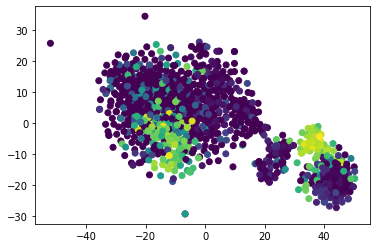

In [28]:
plt.scatter(t.T[0], t.T[1], c=norm_tpm_neuro.loc['Gad2'])

In [8]:
g = []
for row in cell_metric[0]:
    for i in range(1, len(row)):
        g.append((row[0], row[i]))
    
graph = ig.Graph(g)

In [9]:
graph

In [14]:
from igraph import *
layout = graph.layout("kk")
plot(graph, layout = layout, vertex_size=10, vertex_color=norm_tpm_neuro.loc['Cck', rd.index])

ValueError: palette index used when no palette was given

In [22]:
!pip install cairocffi

     |████████████████████████████████| 70 kB 1.8 MB/s  eta 0:00:01
  Created wheel for cairocffi: filename=cairocffi-1.2.0-py3-none-any.whl size=89545 sha256=58c846445b60032b0a00ea4576bf4e8071df4cf7b6e9970a7f34c14e88907eba
  Stored in directory: /mnt/lareaulab/cfbuenabadn/.cache/pip/wheels/e2/ca/86/9db2824f203afe4bdf5aa6ead017f352fcc90e92f095b78871
Successfully built cairocffi
